In [38]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [39]:
!pip install torchvision

In [40]:
root_dir = './classification_dataset_v3_sm/images/train'
for label, class_dir in enumerate(os.listdir(root_dir)): #os.listdir(root_dir): Lists all class folders inside train folder (e.g., cat, dog, etc.).
  print('label:', label, 'class:',class_dir)

label: 0 class: Cat
label: 1 class: Dog
label: 2 class: Person


In [41]:
#boiler plate code
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.class_name = {}
        self.transform = transform

        for label, class_dir in enumerate(os.listdir(root_dir)):
          self.class_name[label] = class_dir
          class_path = os.path.join(root_dir, class_dir)
          #get all image from particular class
          for img_name in os.listdir(class_path):
            self.image_paths.append(os.path.join(class_path, img_name))
            self.labels.append(label)

    def __len__(self):
      return len(self.image_paths)

    def __getitem__(self, idx):
      img_path = self.image_paths[idx]
      label = self.labels[idx]
      image = Image.open(img_path).convert('RGB')
      
      if self.transform:
        image = self.transform(image)

      return image, label

In [42]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), #image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

#ToTensor(): Converts image to PyTorch tensor and scales pixel values from 0–255 to 0–1.

In [43]:
#Applies the custom dataset class to your train/test folders with transformations.
train_img_dir = './classification_dataset_v3_sm/images/train'
test_img_dir = './classification_dataset_v3_sm/images/test'

train_img_dataset = ImageDataset(train_img_dir, transform=transform)
test_img_dataset = ImageDataset(test_img_dir, transform=transform)

In [44]:
train_img_loader = DataLoader(dataset=train_img_dataset, batch_size=32, shuffle=True)
test_img_loader = DataLoader(dataset=test_img_dataset, batch_size=32, shuffle=True)

#DataLoader: Wraps the dataset to provide batches.
#
# batch_size=32: Loads 32 images at once.
#
# shuffle=True: Randomizes order every epoch (important for training).

In [45]:
for images, labels in train_img_loader:
  print(images.shape, labels.shape)
  break

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [46]:
import matplotlib.pyplot as plt
import numpy as np

In [47]:
print(train_img_dataset.class_name, test_img_dataset.class_name)

{0: 'Cat', 1: 'Dog', 2: 'Person'} {0: 'Cat', 1: 'Dog', 2: 'Person'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.99215686].


torch.Size([32, 3, 128, 128]) torch.Size([32])
(3, 128, 128)
Dog
1


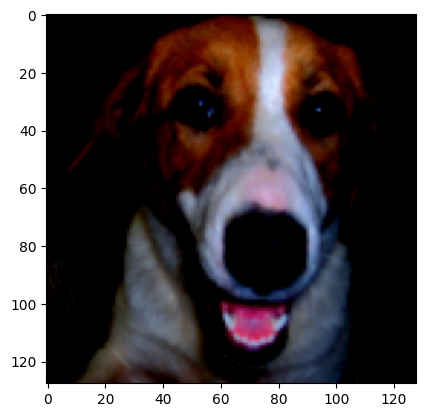

In [188]:
for images, labels in train_img_loader:
  print(images.shape, labels.shape)
  img = images[0].numpy()
  print(img.shape)
  label = labels[0].item()
  print(train_img_dataset.class_name[label])
  img = np.transpose(img, (1, 2, 0))
  print(label)
  plt.imshow(img,vmin =0 , vmax = 1)
  plt.show()
  break

# Custom CNN Architecture

In [189]:
import torch.nn as nn 
import torch.optim as optim 

In [209]:
class CustomCnnModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomCnnModel, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(

            #conv1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),#channel, filters, kernal_size(filter size), stride, padding
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),#kernal size, stride

            #conv2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),#channel, filters, kernal_size(filter size), stride, padding
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #conv3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),#channel, filters, kernal_size(filter size), stride, padding
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            #conv4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),#channel, filters, kernal_size(filter size), stride, padding
            nn.BatchNorm2d(256), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )   

        self._to_linear = None 
        self._get_conv_output(self.input_dim)

        self.fc_layer = nn.Sequential(
            nn.Linear(self._to_linear, 512),
            nn.ReLU(),
            # nn.Dropout(0.2)
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def _get_conv_output(self, input_dim = 128):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, input_dim, input_dim)
            output = self.conv_layers(dummy_input)
            self._to_linear = output.view(1,-1).shape[1]

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layer(x)

In [210]:
#initialize model

model = CustomCnnModel(input_dim=128, num_classes=3).to('cuda' if torch.cuda.is_available() else 'cpu')

In [204]:
print(model)

CustomCnnModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [211]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [215]:
#training loop
losses = []
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for e in range(epochs):
    model.train()
    running_loss = 0.0
    print(f"\nEpoch {e+1}/{epochs}")
    
    for batch_idx, (images, labels) in enumerate(train_img_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 👇 Add this to see training progress
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_img_loader):
            print(f"  Batch {batch_idx+1}/{len(train_img_loader)}, Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_img_loader)
    losses.append(epoch_loss)
    print(f"Epoch {e+1} completed, Average Loss: {epoch_loss:.4f}")





Epoch 1/20
  Batch 10/94, Loss: 0.6016
  Batch 20/94, Loss: 0.3807
  Batch 30/94, Loss: 0.6044
  Batch 40/94, Loss: 0.5282
  Batch 50/94, Loss: 0.4289
  Batch 60/94, Loss: 0.3921
  Batch 70/94, Loss: 0.5352
  Batch 80/94, Loss: 0.4963
  Batch 90/94, Loss: 0.6479
  Batch 94/94, Loss: 0.3771
Epoch 1 completed, Average Loss: 0.5495

Epoch 2/20
  Batch 10/94, Loss: 0.3504
  Batch 20/94, Loss: 0.6900
  Batch 30/94, Loss: 0.6259
  Batch 40/94, Loss: 0.4790
  Batch 50/94, Loss: 0.4466
  Batch 60/94, Loss: 0.5865
  Batch 70/94, Loss: 0.5631
  Batch 80/94, Loss: 0.6019
  Batch 90/94, Loss: 0.6166
  Batch 94/94, Loss: 0.3017
Epoch 2 completed, Average Loss: 0.4922

Epoch 3/20
  Batch 10/94, Loss: 0.5567
  Batch 20/94, Loss: 0.4970
  Batch 30/94, Loss: 0.3361
  Batch 40/94, Loss: 0.4872
  Batch 50/94, Loss: 0.5956
  Batch 60/94, Loss: 0.4358
  Batch 70/94, Loss: 0.4951
  Batch 80/94, Loss: 0.5381
  Batch 90/94, Loss: 0.4923
  Batch 94/94, Loss: 0.5898
Epoch 3 completed, Average Loss: 0.4619

Epo

In [216]:
#save model
torch.save(model.state_dict(), "cnn_model.pth")

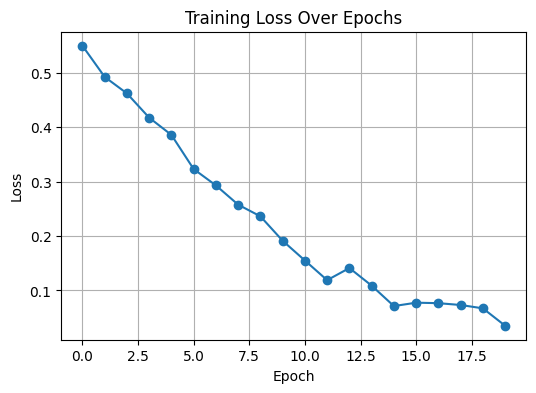

In [217]:
# show loss plot after each epoch
plt.figure(figsize=(6, 4))
plt.plot(losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [219]:
#Eval model

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_img_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) #higher probability will store
        total+=labels.size(0)
        correct+=(predicted == labels).sum().item()
print(f'Test accuracy : {100 * correct / total:.2f}%')
        


Test accuracy : 76.38%


In [220]:
import cv2

In [227]:
class ImageClassifier:
    def __init__(self,model_path, class_names):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = CustomCnnModel(input_dim=128, num_classes=3).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location = self.device)) #load the model
        self.model.eval()
        self.class_names = class_names
        self.transforms = transforms.Compose([
            transforms.Resize((128, 128)), #image size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    
    def predict(self, img_path):
        image  = Image.open(img_path).convert('RGB')
        input_tensor = self.transforms(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.model(input_tensor)
            _, predicted = torch.max(output, 1)
        
            label = self.class_names[predicted.item()]
            img = cv2.imread(img_path)
            cv2.putText(img, label, [10, 30], cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (255, 0, 0), 2)
            cv2.imwrite("output_image.jpg", img)
            return label

In [244]:
classifier = ImageClassifier("./cnn_model.pth", train_img_dataset.class_name)
img_path = "classification_dataset_v3_sm/images/test/Cat/10044.jpg"
label = classifier.predict(img_path)
print(label)

# Read the image
img = cv2.imread("output_image.jpg")

# Display the image in a window
cv2.imshow("Image", img)

# Wait until a key is pressed
cv2.waitKey(0)

# Close all windows
cv2.destroyAllWindows()



Cat
